# Các phương pháp Adams giải bài toán IVPs

### Import packages

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from math import factorial, fabs

### Các hàm bổ trợ

In [27]:
def integ_arr(s, mode="Bashforth"):
    matrix = []
    t = Symbol('t')

    if mode == "Bashforth":
        temp = t
        for i in range(1, s):
            matrix.append(integrate(temp))
            matrix[i-1] = float(matrix[i-1].subs(t, 1)) / factorial(i)
            temp = temp*(t+i)
        matrix.insert(0, 1)
    
    if mode == "Moulton":
        temp = t-1
        for i in range(1, s):
            matrix.append(integrate(temp))
            matrix[i-1] = float(matrix[i-1].subs(t, 1)) / factorial(i)
            temp = temp*(t+i-1)
        matrix.insert(0, 1)
    
    if mode != "Bashforth" and mode != "Moulton":
        return "fail"
    else:
        return np.array(matrix)

In [28]:
def pascal(n):
    pas = np.zeros([n, n])
    for i in range(n):
        pas[i,0] = 1
        for j in range(1, i+1):
            pas[i,j] = pas[i-1,j-1]*(-1) + pas[i-1,j]
    return pas

### Input chương trình

In [29]:
def func(u, v):
    return 3 * (v/u)
    # return -3 * v
def real_root(u):
    return 3*u**3

# x0 = 1
# y0 = 3
# X  = 3
# h  = 0.2
# S  = 3

## 1. Adams - Bashforth (ngoại suy)

<b>Ý tưởng</b>:
Xấp xỉ $y'(x)$ trên $[x_{n-1}, x_n]$ bằng đa thức nội suy với s điểm nội suy $\{x_{n-i}, f_{n-i}\}_{i=\bar{1,s}}$

Sử dụng đa thức nội suy Newton lùi mốc cách đều xuất phát từ $x_{n-1}$:
$$P = f_{n-1}+\nabla f_{n-1}t+\frac{\nabla^2f_{n-2}}{2!}t(t+1)+...+\frac{\nabla^{s-1}f_{n-1}}{(s-1)!}t(t+1)...(t+s-2)$$

Xét phép đổi biến $x=x_{n-1}+th$, ta được:
$$\begin{array}{lcl}
y_n&=&y_{n-1}+\int_{x_{n-1}}^{x_n}f(x,y(x))dx  \\
&\approx& y_{n-1} + \int_0^1(f_{n-1}+\nabla f_{n-1}t+\frac{\nabla^2f_{n-2}}{2!}t(t+1)+...+\frac{\nabla^{s-1}f_{n-1}}{(s-1)!}t(t+1)...(t+s-2))dx
\end{array}$$

Đặt
$$a_i=\frac{1}{i!}\int_0^1t(t+1)...(t+i-1)dt$$

Áp dụng công thức sai phân:
$$\begin{array}{lcl}
\nabla y'_{i-1}&=&y'_{i-1}-y'_{i-2} \\
\nabla^2 y'_{i-1} &=& \nabla y'_{i-1} - \nabla y'_{i-2} \\
........................................................
\end{array}$$

Khi đó, ta có:
$$y_i = y_{i-1}+h.(b_0*+*y'_{i-1}+b_1*y'_{i-2}+...+b_{s-1}*y'_{i-s}) $$
Với
$$\begin{pmatrix}
b_0 & b_1 & ... & b_{s-1}
\end{pmatrix}
=
\begin{pmatrix}
a_0 & a_1 & ... & a_{s-1}
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & ... & 0 \\
1 & -1 & 0 & ... & 0 \\
1 & -2 & 1 & ... & 0 \\
... & ... & ... & ... & ...
\end{pmatrix}$$

In [30]:
def Bashforth_Coefficient(s):
    return integ_arr(s, mode="Bashforth").dot(pascal(s))

In [31]:
def Adams_Bashforth(x0=1, xn=3, y0=3, h=0.2, s=4):
    n = floor((xn-x0) / h)
    X = []
    Y = [y0]

    for i in range(n+1):
        X.append(x0 + i*h)
    
    # Tính hệ số công thức AB
    coeff = Bashforth_Coefficient(s)

    # Tính s giá trị khởi đầu dựa theo RK4
    for i in range(1, s):
        k1 = h * func(X[i-1], Y[i-1])
        k2 = h * func(X[i-1] + h/2, Y[i-1] + k1/2)
        k3 = h * func(X[i-1] + h/2, Y[i-1] + k2/2)
        k4 = h * func(X[i-1] + h, Y[i-1] + k3)
        Y.append(Y[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
    
    for i in range(s, n+1):
        temp = 0
        for j in range(s):
            temp = temp + (h * coeff[j] * func(X[i-j-1], Y[i-j-1]))
        Y.append(Y[i-1] + temp)
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

## 2. Adams - Moulton (nội suy)

<b>Ý tưởng</b>:
Xấp xỉ $y'(x)$ trên $[x_{n-1}, x_n]$ bằng đa thức nội suy với s+1 điểm nội suy $\{x_{n-i}, f_{n-i}\}_{i=\bar{0,s}}$

Sử dụng đa thức nội suy Newton lùi mốc cách đều xuất phát từ $x_n$:
$$\begin{array}{lcl}
y_n&=&y_{n-1}+\int_{x_{n-1}}^{x_n}f(x,y(x))dx  \\
&\approx& y_{n-1} + \int_{-1}^0(f_{n}+\nabla f_{n}t+\frac{\nabla^2f_{n}}{2!}t(t+1)+...+\frac{\nabla^{s-1}f_{n}}{(s-1)!}t(t+1)...(t+s-2))dx
\end{array}$$

// Cần bổ sung thêm

In [32]:
def Moulton_Coefficient(s):
    return integ_arr(s, mode="Moulton").dot(pascal(s))

In [33]:
def Adams_Moulton(x0=1, xn=3, y0=3, h=0.2, s=4, eps=10**-5):
    n = floor((xn-x0) / h)
    X = []
    Y = [y0]
    
    for i in range(n+1):
        X.append(x0 + i*h)
    
    # Tính hệ số công thức AM
    coeff = Moulton_Coefficient(s)

    # Tính s giá trị khởi đầu dựa theo RK4
    for i in range(1, s):
        k1 = h * func(X[i-1], Y[i-1])
        k2 = h * func(X[i-1] + h/2, Y[i-1] + k1/2)
        k3 = h * func(X[i-1] + h/2, Y[i-1] + k2/2)
        k4 = h * func(X[i-1] + h, Y[i-1] + k3)
        Y.append(Y[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
    
    for i in range(s, n+1):
        delta = 0
        for j in range(1, s):
            delta += h * coeff[j] * func(X[i-j], Y[i-j])
        Y.append(Y[i-1] + h * coeff[0] * func(X[i], Y[i-1]) + delta)
        y_pre = Y[i-1] + h * coeff[0] * func(X[i], Y[i]) + delta

        while (fabs(y_pre - Y[i]) >= eps):
            Y[i] = y_pre
            y_pre = Y[i-1] + h * coeff[0] * func(X[i], Y[i]) + delta
        Y[i] = y_pre
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

## 3. Phương pháp dự báo hiệu chỉnh (AB - AM)

<ul>
    <li>AB dự báo giá trị</li>
    <li>AM hiệu chỉnh bằng công thức lặp sinh ra từ phương trình lặp AM</li>
</ul>

Phương pháp này được sử dụng để đạt hiệu quả tương tự như AM nhưng với số lần lặp ít hơn nhiều.

In [34]:
def Adams_Bashforth_Moulton(x0=1, xn=3, y0=3, h=0.2, s=4, eps=10**-5):
    n = floor((xn-x0) / h)
    X = []
    Y = [y0]
    
    for i in range(n+1):
        X.append(x0 + i*h)
    
    # Tính s giá trị khởi đầu dựa theo RK4
    for i in range(1, s):
        k1 = h * func(X[i-1], Y[i-1])
        k2 = h * func(X[i-1] + h/2, Y[i-1] + k1/2)
        k3 = h * func(X[i-1] + h/2, Y[i-1] + k2/2)
        k4 = h * func(X[i-1] + h, Y[i-1] + k3)
        Y.append(Y[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
    
    # Tính hệ số công thức AB-AM    
    bash_coeff = Bashforth_Coefficient(s)
    moul_coeff = Moulton_Coefficient(s)
    
    for i in range(s, n+1):
        # Dùng AB để dự đoán
        estimate = Y[i-1]
        for j in range(s):
            estimate += h * bash_coeff[j] * func(X[i-j-1], Y[i-j-1])
        
        # Dùng AM để hiệu chỉnh
        delta = 0
        for k in range(1, s):
            delta += h * moul_coeff[k] * func(X[i-k], Y[i-k])
        Y.append(Y[i-1] + h * moul_coeff[0] * func(X[i],estimate) + delta)
        ym = Y[i-1] + h * moul_coeff[0] * func(X[i],Y[i]) + delta
        
        while fabs(ym - Y[i]) >= eps:
            Y[i] = ym
            ym   = Y[i-1] + h * moul_coeff[0] * func(X[i], Y[i]) + delta
        Y[i] = ym
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

## 4. Kết quả chạy chương trình

<b>Lưu ý:</b>
<ol>
    <li>Đối với AM và AB-AM, có thể thêm biến đếm trong vòng lặp để so sánh số lượng vòng lặp của 2 phương pháp</li>
    <li>Với AB-AM, có thể chỉ cần lặp một lần để ra kết quả</li>
</ol>

### 4.1 AB

In [35]:
x0 = 1
xn = 3
y0 = 3
h = 0.5
n = floor((xn-x0) / h)

X_real = []
Y_real = []

for i in range(n+1):
    X_real.append(x0 + i*h)
    Y_real.append(real_root(X_real[i]))

X_real = np.array(X_real)
Y_real = np.array(Y_real)

[ 3.          5.18264463  8.2288539  12.28254407 17.48812525 23.98931497
 31.92977333 41.45348238 52.70445417 65.82660307 80.96384281]
[ 3.    10.125 24.    46.875 81.   ]


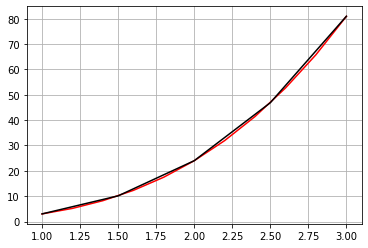

In [36]:
x_found, y_found = Adams_Bashforth()

# c = 100000000
# y_found *= c
# Y_real *= c
print(y_found, Y_real, sep='\n')


plt.grid()
plt.plot(x_found, y_found, 'red')
plt.plot(X_real, Y_real, 'black')
plt.show()

### 4.2 AM

[ 3.          5.18264463  8.2288539  12.28254407 17.48820198 23.98931164
 31.92977363 41.4535296  52.70451607 65.82666885 80.96392376]
[ 3.    10.125 24.    46.875 81.   ]


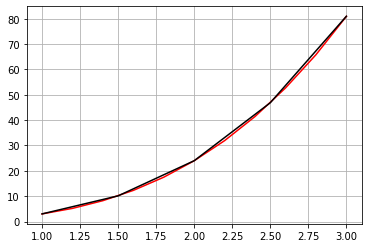

In [37]:
x_found, y_found = Adams_Moulton()

# c = 100000000
# y_found *= c
# Y_real *= c
print(y_found, Y_real, sep='\n')


plt.grid()
plt.plot(x_found, y_found, 'red')
plt.plot(X_real, Y_real, 'black')
plt.show()

### 4.3 AB - AM

[ 3.          5.18264463  8.2288539  12.28254407 17.48820108 23.98931073
 31.92977265 41.45352889 52.70451561 65.82666856 80.96392361]
[ 3.    10.125 24.    46.875 81.   ]


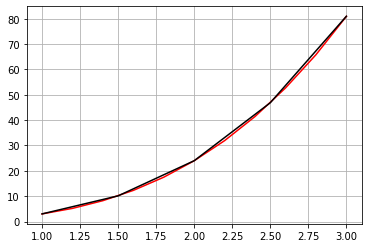

In [38]:
x_found, y_found = Adams_Bashforth_Moulton()

# c = 100000000
# y_found *= c
# Y_real *= c
print(y_found, Y_real, sep='\n')


plt.grid()
plt.plot(x_found, y_found, 'red')
plt.plot(X_real, Y_real, 'black')
plt.show()